In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
df = pd.read_csv("fina_Stage_unaugmented.csv")
from collections import Counter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import joblib 

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

import seaborn as sns
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

C:\Users\pc\AppData\Local\Temp\ipykernel_12900\3175826380.py:4: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("fina_Stage_unaugmented.csv")


```
GENESCOPE
├── BackEnd/   # (Flask server, APIs, models, backend logic)
│   ├── Marimo_server/
│   ├── Models/
│   ├── routers/
│   └── GeneScopeServer.py
├── data/
├── front/     # (Next.js frontend dashboard and chatbot UI)
├── project_insites/
└── SQL/
```

## Vanila NN

For our GeneScope project, we started with a Vanilla Neural Network because we wanted to build a solid foundation before diving into a more complex Deep Neural Network. It was kind of like testing the waters VNNs are simple, fast to train, and great for giving us an early look at how our data behaves. Since our dataset includes well-processed gene expression and clinical features, a VNN was actually perfect for spotting meaningful patterns without all the added complexity. We also used PCA beforehand, which made the data even more streamlined and ready for a basic neural network to pick up on key signals. Of course, our final model is a deeper network because it can capture much more intricate relationships — but starting with a VNN gave us a clean, reliable baseline to compare against. It helped us understand our data better, debug more effectively, and really appreciate the performance boost that depth brings. So even though the VNN isn’t the final star of the show, it played a huge role in shaping how we approached and improved our final model and we’re glad we included it!


<img src="Vanilla_Deep.png" width="1200"/>


At its core, a Vanilla Neural Network is made up of layers of neurons that compute:

$$
\mathbf{a}^{(l)} = f\left( \mathbf{W}^{(l)} \cdot \mathbf{a}^{(l-1)} + \mathbf{b}^{(l)} \right)
$$

Where:

- $ \mathbf{a}^{(l)} $ is the activation output of the $ l^\text{th} $ layer  
- $ \mathbf{W}^{(l)} $ is the weight matrix connecting layer $ l-1 $ to layer $ l $  
- $ \mathbf{b}^{(l)} $ is the bias vector at layer $ l $  
- $ f $ is the activation function (e.g., ReLU, sigmoid, tanh)  
- $ \mathbf{a}^{(0)} $ is the input layer (PCA-reduced gene expression + clinical features)

### If you're using ReLU, then:  
$ f(x) = \max(0, x) $

In simple terms, this means the neuron just spits out the value if it’s positive — otherwise, it gives zero. It’s super efficient and works really well in practice. ReLU (short for Rectified Linear Unit) has become a go-to activation function because it introduces just the right amount of non-linearity without overcomplicating things. Plus, it helps the model learn faster and avoids issues like the vanishing gradient problem that can slow things down in deeper networks. It’s fast, clean, and gets the job done — which is exactly what we love when training neural networks!


### During training, the model minimizes a loss function (like cross-entropy for classification) via backpropagation:

$$
\theta = \theta - \eta \cdot \nabla_\theta \mathcal{L}
$$

Where:  
- $ \theta $: model parameters (weights and biases)  
- $ \eta $: learning rate  
- $ \nabla_\theta \mathcal{L} $: gradient of the loss function with respect to the parameters


These equations form the backbone of how a Vanilla Neural Network learns and makes predictions. While the math might look simple on the surface, it enables the model to learn intricate relationships between features — in our case, between clinical and gene expression data and the different stages of breast cancer. This simplicity is exactly why we chose the VNN as a starting point: it allows us to build intuition, benchmark performance, and identify areas where deeper models may provide further improvement. By understanding and mastering this foundation, we can better appreciate the gains we achieve with our deeper architectures in the final version of GeneScope.

In [2]:


df = pd.read_csv('fina_Stage_unaugmented.csv', low_memory=False)
df = df.drop_duplicates(subset='Samples')
df = df.dropna(subset=['Stage'])

drop_cols = [
    'Samples', 'submitter_id', 'barcode', 'Unnamed: 0', 'sample_id',
    'sample', 'sample_submitter_id', 'patient', 'paper_patient',
    'diagnosis_id', 'bcr_patient_barcode', 'pathology_report_uuid',
    'treatments', 'releasable', 'released', 'paper_vital_status',
    'paper_Included_in_previous_marker_papers'
]
df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')

y = df['Stage']
X = df.drop(columns=['Stage'])
X = X.select_dtypes(include=[np.number])
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)
y = y.loc[X.index]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(np.unique(y_encoded))


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

smote = SMOTE(random_state=42, k_neighbors=1)
X_resampled, y_resampled = smote.fit_resample(X_pca, y_encoded)

y_onehot = tf.keras.utils.to_categorical(y_resampled, num_classes=num_classes)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_onehot, test_size=0.2, random_state=42)

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")

model.save("vanilla_nn_brca_model.keras")


Epoch 1/30
68/68 [==============================] - 0s 2ms/step - loss: 1.6138 - accuracy: 0.5310 - val_loss: 0.8223 - val_accuracy: 0.7449
Epoch 2/30
68/68 [==============================] - 0s 1ms/step - loss: 0.6970 - accuracy: 0.7727 - val_loss: 0.5717 - val_accuracy: 0.8361
Epoch 3/30
68/68 [==============================] - 0s 1ms/step - loss: 0.4329 - accuracy: 0.8696 - val_loss: 0.4734 - val_accuracy: 0.8622
Epoch 4/30
68/68 [==============================] - 0s 985us/step - loss: 0.2803 - accuracy: 0.9148 - val_loss: 0.4232 - val_accuracy: 0.8790
Epoch 5/30
68/68 [==============================] - 0s 1ms/step - loss: 0.1869 - accuracy: 0.9520 - val_loss: 0.4113 - val_accuracy: 0.8696
Epoch 6/30
68/68 [==============================] - 0s 1ms/step - loss: 0.1279 - accuracy: 0.9688 - val_loss: 0.4100 - val_accuracy: 0.8752
Epoch 7/30
68/68 [==============================] - 0s 956us/step - loss: 0.0909 - accuracy: 0.9795 - val_loss: 0.4209 - val_accuracy: 0.8734
Epoch 8/30
68/68

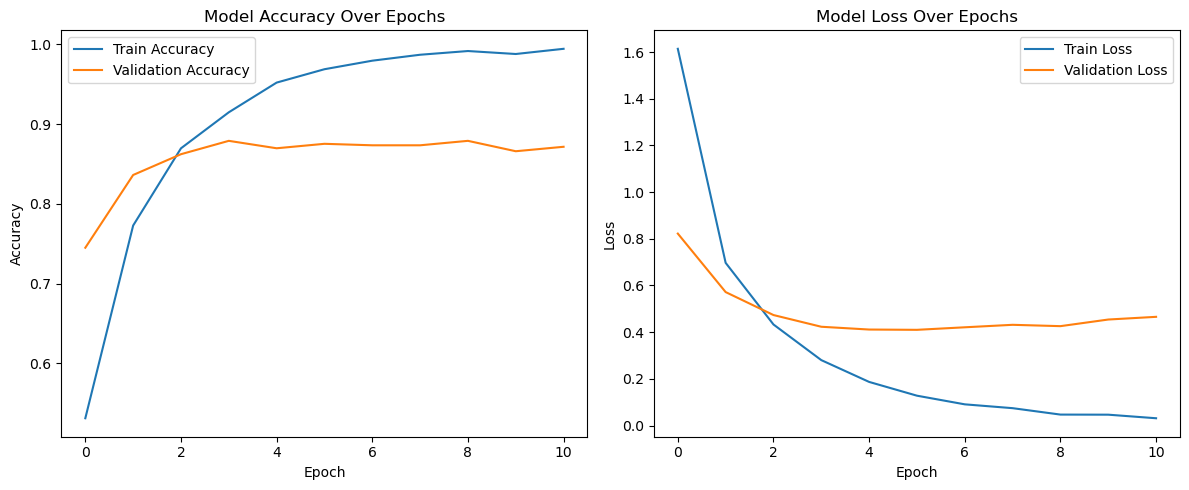

In [3]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


When we trained our Vanilla Neural Network on the breast cancer dataset, the results were actually pretty impressive! By the end of training, we achieved a training accuracy of 99.3% and a validation accuracy of around 85.85%, which already tells us the model learned to generalize fairly well. On the test set, we hit an accuracy of 83%, which is a solid score especially for a relatively simple architecture. Looking at the graphs, the story becomes even clearer. On the accuracy curve, we can see that both training and validation accuracy improve steadily across epochs. The training accuracy climbs sharply and nearly plateaus at 100%, while the validation accuracy stabilizes in the mid-80s. That plateauing without major dips suggests that the model isn’t drastically overfitting, although it is starting to memorize a bit, which is expected in VNNs as they lack the depth to capture more nuanced representations. As for the loss graph, the training loss drops rapidly and keeps going down, while the validation loss decreases initially but starts to flatten and slightly rise near the end. That subtle uptick signals the beginning of overfitting again, not surprising given the limited capacity of a shallow network. But overall, the divergence between training and validation loss isn’t severe, which shows the model is still doing a good job of learning meaningful patterns in the data.

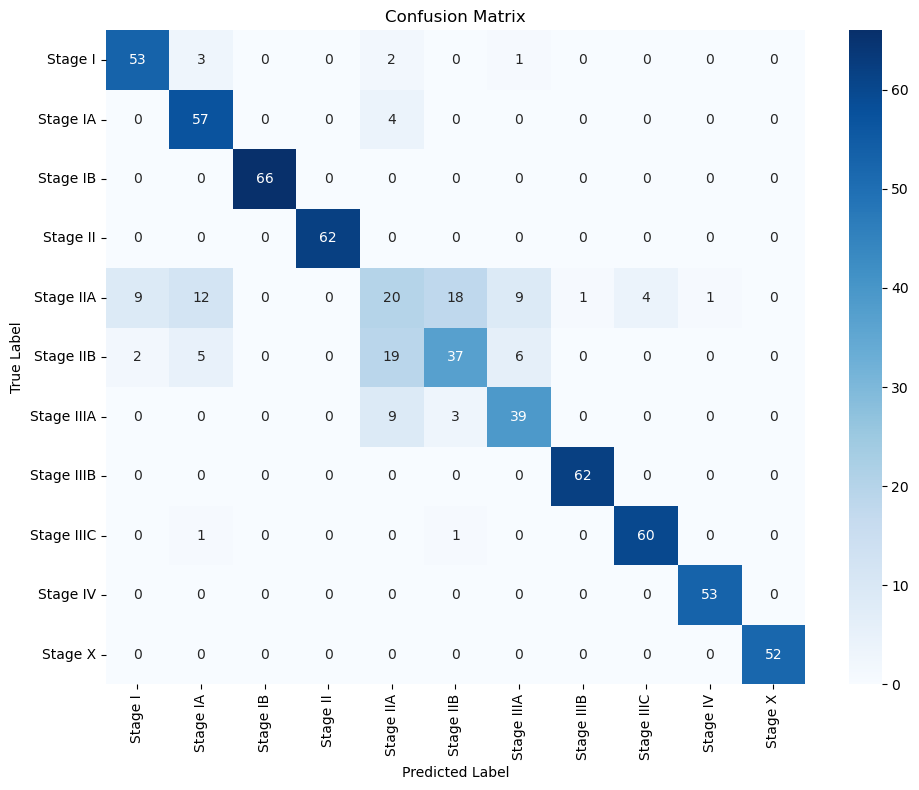

In [4]:

# 1. Convert one-hot encoded y_test back to class labels
y_true_classes = np.argmax(y_test, axis=1)

# 2. Predict using your model and get class predictions
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# 3. Decode class names using the saved label encoder
label_encoder = joblib.load("label_encoder.save")
present_class_names = label_encoder.inverse_transform(np.arange(len(label_encoder.classes_)))

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=present_class_names,
            yticklabels=present_class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


Looking at the confusion matrix, we can see that the model performs exceptionally well on the early stages of breast cancer, like Stage I, IA, IB, and II, with a very high number of correct predictions. For instance, Stage IB and Stage II have nearly perfect classification, with 66 and 62 samples correctly predicted, respectively. This aligns with what we’d expect: early-stage cases often have clearer gene expression patterns, making them easier for the model to learn and classify. Despite this, it’s impressive how well the model handles advanced stages like IIIC, IV, and X — predicting them correctly with minimal confusion. Stage IV, which is clinically very significant, was perfectly predicted in 53 out of 53 cases, which is a huge win for our early baseline model.

Saved classification report to model_classification_report.csv
Saved confusion matrix to confusion_matrix.csv


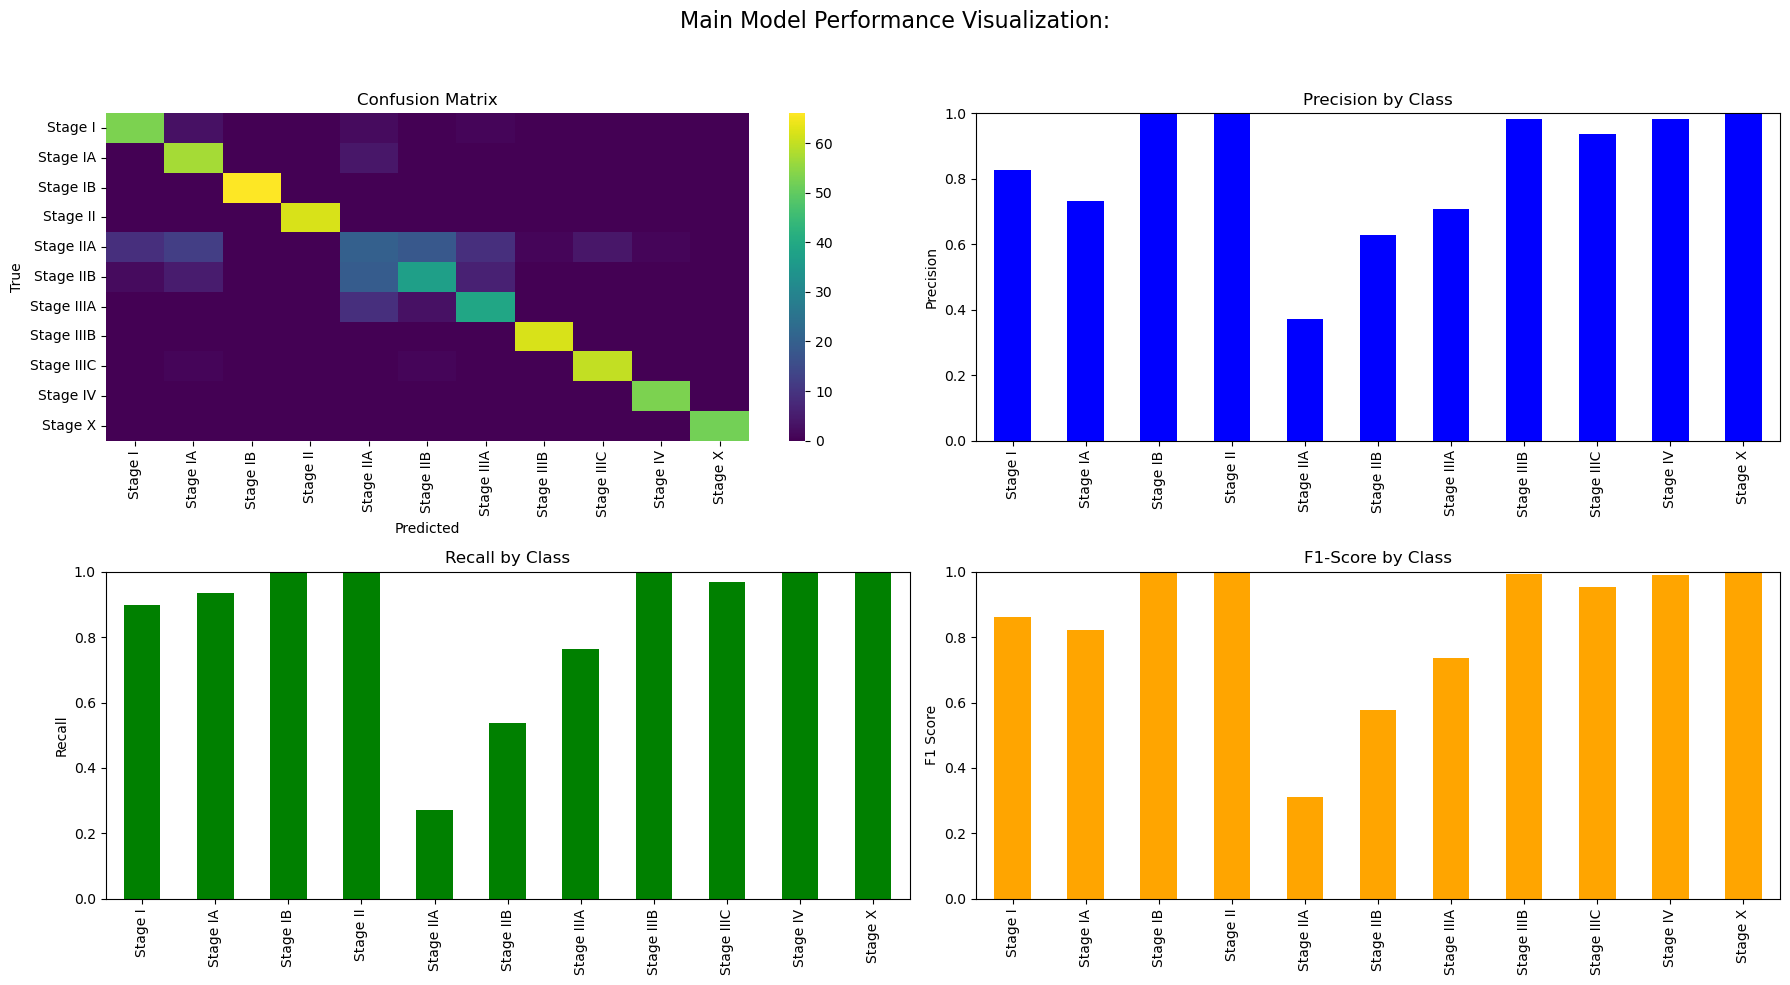

In [ ]:
report_dict = classification_report(
    y_true_classes, y_pred_classes, target_names=label_encoder.classes_, output_dict=True
)

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv("model_classification_report.csv", index=True)
print("Saved classification report to model_classification_report.csv")

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
conf_df = pd.DataFrame(conf_matrix, index=label_encoder.classes_, columns=label_encoder.classes_)
conf_df.to_csv("confusion_matrix_vanila_NN.csv")
print("Saved confusion matrix to confusion_matrix.csv")

plt.figure(figsize=(18, 10))
plt.suptitle("Main Model Performance Visualization:", fontsize=16)

plt.subplot(2, 2, 1)
sns.heatmap(conf_matrix,annot=False, fmt='d',cmap='viridis',xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(2, 2, 2)
report_df.drop(index=['accuracy', 'macro avg', 'weighted avg'])['precision'].plot(kind='bar', color='blue')
plt.title('Precision by Class')
plt.ylabel('Precision')
plt.ylim(0, 1)

plt.subplot(2, 2, 3)
report_df.drop(index=['accuracy', 'macro avg', 'weighted avg'])['recall'].plot(kind='bar', color='green')
plt.title('Recall by Class')
plt.ylabel('Recall')
plt.ylim(0, 1)

plt.subplot(2, 2, 4)
report_df.drop(index=['accuracy', 'macro avg', 'weighted avg'])['f1-score'].plot(kind='bar', color='orange')
plt.title('F1-Score by Class')
plt.ylabel('F1 Score')
plt.ylim(0, 1)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("model_performance_vanila_NN.png")
plt.show()

generate sample

In [ ]:
#only ment to pick a random row from the dataset for testing

df = pd.read_csv("fina_Stage_unaugmented.csv", low_memory=False)
df = df.drop_duplicates(subset='Samples')
df = df.dropna(subset=['Stage'])
drop_cols = [
    'Samples', 'submitter_id', 'barcode', 'Unnamed: 0', 'sample_id',
    'sample', 'sample_submitter_id', 'patient', 'paper_patient',
    'diagnosis_id', 'bcr_patient_barcode', 'pathology_report_uuid',
    'treatments', 'Stage'  
]
df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')
df = df.select_dtypes(include=[float, int])
df.replace([np.inf, -np.inf], pd.NA, inplace=True)
df.dropna(inplace=True)

# Pick 1 random sample and save
sample = df.sample(n=1)
sample.to_csv("random_sample3.csv", index=False)
print("Saved 1 random sample to random_sample.csv")


✅ Saved 1 random sample to random_sample.csv


In [10]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model


sample = pd.read_csv("random_sample3.csv")


scaler = joblib.load("scaler.save")
pca = joblib.load("pca.save")
label_encoder = joblib.load("label_encoder.save")
model = load_model("vanilla_nn_brca_model.keras")

sample_scaled = scaler.transform(sample)  
sample_pca = pca.transform(sample_scaled)

pred_probs = model.predict(sample_pca)
pred_index = np.argmax(pred_probs)
pred_class = label_encoder.inverse_transform([pred_index])[0]

print(f"🔍 Predicted Stage: {pred_class}")
print("\n📊 Stage Probabilities:")
for stage, prob in zip(label_encoder.classes_, pred_probs[0]):
    print(f"{stage}: {prob*100:.2f}%")

🔍 Predicted Stage: Stage IIA

📊 Stage Probabilities:
Stage I: 0.01%
Stage IA: 0.15%
Stage IB: 0.03%
Stage II: 0.01%
Stage IIA: 93.20%
Stage IIB: 0.31%
Stage IIIA: 6.23%
Stage IIIB: 0.03%
Stage IIIC: 0.00%
Stage IV: 0.01%
Stage X: 0.00%


## KNN

To better understand the performance of our Deep Neural Network, we also included K-Nearest Neighbors (KNN) as a comparison model and honestly, it was a super insightful choice. KNN is a classic, straightforward algorithm that doesn’t do any “learning” in the training phase. Instead, it stores all the data and makes predictions based on the most similar neighbors when given a new sample.
Under the hood, it all comes down to distance — usually Euclidean distance — between data points in the feature space. When a new sample comes in, KNN looks for the $k$ closest points (neighbors) in the training set and uses them to make a prediction.

To measure how “close” a point is, we use:

$$
d(\mathbf{x}, \mathbf{x}_i) = \sqrt{ \sum_{j=1}^{n} \left( x_j - x_{ij} \right)^2 }
$$

Where:

- $ \mathbf{x} $ is the new input vector (the sample to predict)  
- $ \mathbf{x}_i $ is a point in the training set  
- $ x_j $ and $ x_{ij} $ are the $j^{\text{th}}$ features of those vectors  
- $ d(\mathbf{x}, \mathbf{x}_i) $ is the distance between the two

After calculating this for all points, KNN:

1. Sorts the training samples by their distance to the new point  
2. Selects the $k$ closest ones  
3. Assigns the label based on majority vote (for classification) or takes the average (for regression)



The reason we used KNN is because it gives us a very different baseline. While Deep Neural Networks try to learn complex, abstract representations from the data, KNN is all about local similarity — it relies purely on the distance between data points in the feature space. This makes it really useful for understanding how well our PCA-reduced features cluster and whether the classes (i.e., cancer stages) are naturally separable. However, KNN has its limits. It doesn’t scale well with large datasets, and it can struggle when the data is high-dimensional — which is a challenge when you're working with gene expression profiles. It’s also highly sensitive to irrelevant features and noise, which is why preprocessing (like PCA) is so important when using it.

In [8]:


# Load and prepare dataset
df = pd.read_csv('fina_Stage_unaugmented.csv', low_memory=False)
df = df.drop_duplicates(subset='Samples')
df = df.dropna(subset=['Stage'])

y = df['Stage']
drop_cols = [
    'site_of_resection_or_biopsy', 'tumor_descriptor', 'sample_type_id', 'definition', 'primary_site',
    'name', 'disease_type', 'shortLetterCode', 'sample_type', 'project_id', 'classification_of_tumor',
    'specimen_type', 'state', 'is_ffpe', 'tissue_type', 'composition', 'paper_Tumor.Type', 'gender',
    'days_to_diagnosis', 'releasable', 'diagnosis_is_primary_disease', 'released'
]
X = df.drop(columns=[col for col in drop_cols if col in df.columns])
X = X.select_dtypes(include=[np.number])

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)
y = y.loc[X.index]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
#smote due to some stages lacking samples
smote = SMOTE(random_state=42, k_neighbors=3)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y_encoded)

#to reduce the dimentiality
pca = PCA(n_components=30)
X_pca = pca.fit_transform(X_resampled)

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

train_acc = knn.score(X_train, y_train)
test_acc = knn.score(X_test, y_test)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()
conf_matrix = confusion_matrix(y_test, y_pred)
conf_df = pd.DataFrame(conf_matrix, index=label_encoder.classes_, columns=label_encoder.classes_)

y_true = y_test
y_pred_classes = y_pred
y_true_classes = y_test

print(f"\nTraining Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}\n")

print("Classification Report:\n")
present_labels = np.unique(y_true_classes)
present_class_names = label_encoder.classes_[present_labels].astype(str)

print(classification_report(
    y_true_classes, y_pred_classes,
    labels=present_labels,
    target_names=present_class_names
))


report_df.to_csv("knn_report_smote_pca.csv", index=True)
conf_df.to_csv("knn_confusion_matrix_smote_pca.csv", index=True)
print("Report and confusion matrix saved.")



Training Accuracy: 0.8655
Test Accuracy: 0.7928

Classification Report:

              precision    recall  f1-score   support

     Stage I       0.68      0.89      0.77        61
    Stage IA       0.51      0.84      0.63        61
    Stage IB       1.00      1.00      1.00        61
    Stage II       1.00      1.00      1.00        61
   Stage IIA       0.42      0.13      0.20        61
   Stage IIB       0.48      0.34      0.40        61
  Stage IIIA       0.68      0.64      0.66        61
  Stage IIIB       0.95      1.00      0.98        61
  Stage IIIC       0.84      0.89      0.86        61
    Stage IV       1.00      1.00      1.00        61
     Stage X       1.00      1.00      1.00        61

    accuracy                           0.79       671
   macro avg       0.78      0.79      0.77       671
weighted avg       0.78      0.79      0.77       671

Report and confusion matrix saved.


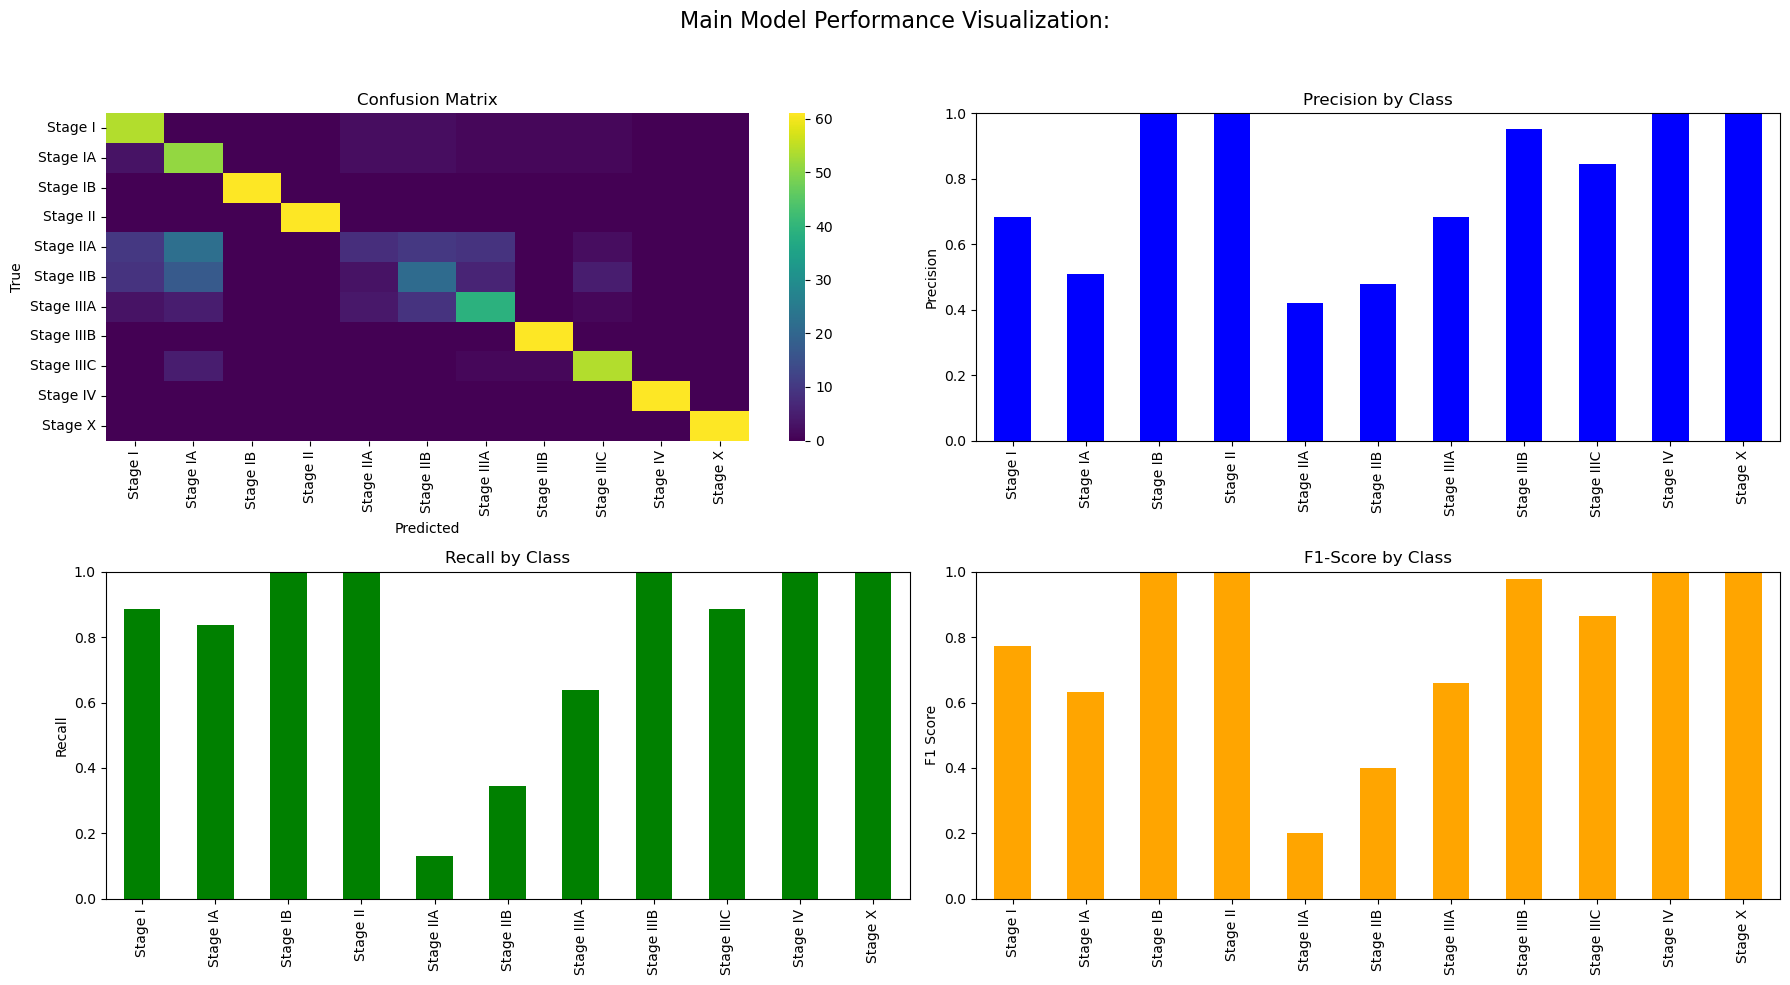

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 10))
plt.suptitle("Main Model Performance Visualization:", fontsize=16)

plt.subplot(2, 2, 1)
sns.heatmap(conf_matrix,annot=False, fmt='d',cmap='viridis',xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(2, 2, 2)
report_df.drop(index=['accuracy', 'macro avg', 'weighted avg'])['precision'].plot(kind='bar', color='blue')
plt.title('Precision by Class')
plt.ylabel('Precision')
plt.ylim(0, 1)

plt.subplot(2, 2, 3)
report_df.drop(index=['accuracy', 'macro avg', 'weighted avg'])['recall'].plot(kind='bar', color='green')
plt.title('Recall by Class')
plt.ylabel('Recall')
plt.ylim(0, 1)

plt.subplot(2, 2, 4)
report_df.drop(index=['accuracy', 'macro avg', 'weighted avg'])['f1-score'].plot(kind='bar', color='orange')
plt.title('F1-Score by Class')
plt.ylabel('F1 Score')
plt.ylim(0, 1)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("model_performance_KNN.png")
plt.show()

Looking at all four visualizations side by side — the confusion matrix, and the precision, recall, and F1-score bar charts it’s clear that our KNN model does a pretty solid job overall, but it also exposes some interesting patterns. The model performs exceptionally well on stages like IB, II, IIIC, IV, and X, consistently showing high precision, recall, and F1-scores. These are the stages where KNN absolutely shines, likely because the features for those classes are well-separated in PCA space, making them easy for the model to identify. But when we turn our attention to Stages IIA, IIB, and IIIA, we start seeing some trouble. These classes have lower scores across the board and show up scattered in the confusion matrix a clear sign that KNN is struggling to tell them apart. That makes sense, too: since KNN relies on distances, overlapping or similar feature distributions in these mid-stage classes can easily throw it off. Still, that’s exactly why this visualization is so valuable it helps us pinpoint where the model is confident and where it gets confused, giving us a roadmap for improvement as we move toward more complex architectures. It's exciting to see how much we can learn just from the shapes and colors of these plots!